In [1]:
import html
import math
import random
import re
import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch
from datasets import load_dataset, load_from_disk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

sys.path.append("../../")

from models import Transformer, VanillaTransformerArgs
from utils.datasets import TextPairDataCollate, TextPairDataset
from utils.helpers import (
    bleu_score,
    count_params,  # noqa: E402
    create_pad_mask,
    create_subsequent_mask,
    translate_one_sentence,
)
from utils.tokenizers import BPETokenizer

### Data preparation

#### 1. Data cleaning

In [ ]:
vi_en_dataset = load_dataset(
    "mt_eng_vietnamese", "iwslt2015-vi-en", cache_dir="datasets"
)


def clean(batch):
    en = html.unescape(batch["translation"]["en"]).lower()
    vi = html.unescape(batch["translation"]["vi"]).lower()

    en = re.sub(r"\s+", " ", en).strip()
    en = " ".join(list(filter(lambda x: len(x), en.split())))
    batch["en"] = en

    vi = re.sub(r"\s+", " ", vi).strip()
    vi = " ".join(list(filter(lambda x: len(x), vi.split())))
    batch["vi"] = vi

    return batch


del vi_en_dataset["validation"]
vi_en_dataset = vi_en_dataset.map(clean, remove_columns="translation")
vi_en_dataset.save_to_disk("datasets/cleaned")

#### 2. Token indexing

In [6]:
tokenizer = BPETokenizer()
tokenizer.load_state_dict(torch.load("tokenizers/bpe-20k.pth"))
vi_en_dataset = load_from_disk("datasets/cleaned")

In [ ]:
def token2idx(batch):
    batch["ids_vi"] = (
        [tokenizer._st2i[tokenizer.sos]]
        + tokenizer(batch["vi"])
        + [tokenizer._st2i[tokenizer.eos]]
    )
    batch["ids_en"] = tokenizer(batch["en"])

    return batch


vi_en_ids = vi_en_dataset.map(
    token2idx, remove_columns=vi_en_dataset.column_names["train"]
)

In [9]:
max_length = 256

In [5]:
vi_en_ids = vi_en_ids.filter(
    lambda batch: 2 < len(batch["ids_vi"]) <= max_length
    and 1 <= len(batch["ids_en"]) <= max_length
)

Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/cleaned/train/cache-cd00f4074883befb.arrow


Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/cleaned/test/cache-1a03afa89389bcff.arrow


In [ ]:
train, val = vi_en_ids["train"].train_test_split(test_size=0.01).values()
vi_en_ids.update({"train": train, "val": val})
vi_en_ids.save_to_disk("datasets/processed_ids_splits_20k")

#### 3. Experiments

In [4]:
vi_en_ids = load_from_disk("datasets/processed_ids_splits_20k")
vi_en_ids

DatasetDict({
    train: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 131804
    })
    test: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 1268
    })
    val: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 1332
    })
})

In [7]:
print("".join(tokenizer.decode(vi_en_ids["train"]["ids_en"][33])))

in any war today , most of the casualties are civilians , mainly women and children . they are collateral damage .


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_args = VanillaTransformerArgs(
    vocab_size=len(tokenizer),
    n_heads=4,
    n_blocks=2,
    d_model=64,
    d_ff=4 * 64,
    d_k=64 // 4,
    d_v=64 // 4,
    max_length=max_length,
    p_drop=0.1,
)

model = Transformer(model_args).to(device)
count_params(model)

optimizer = Adam(model.parameters(), lr=0.0002, betas=(0.98, 0.99))
scheduler = ExponentialLR(optimizer, 0.99**0.125)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer._st2i[tokenizer.pad])

Total: 1,531,936 parameters.
Trainable: 1,531,936 parameters.


In [11]:
lre = torch.linspace(-6, -0.6, 1000)

In [ ]:
tp_collate = TextPairDataCollate(tokenizer)

val_dl = DataLoader(
    TextPairDataset(vi_en_ids["val"]["ids_en"][:10], vi_en_ids["val"]["ids_vi"][:10]),
    batch_size=32,
    pin_memory=True,
    shuffle=False,
    collate_fn=tp_collate,
)

losses = []
lrs = []
i = 0
while i < len(lre):
    for src, src_lens, tgt, tgt_lens in val_dl:
        src, src_lens, tgt, tgt_lens = (
            src.to(device),
            src_lens.to(device),
            tgt.to(device),
            tgt_lens.to(device),
        )

        src_mask = create_pad_mask(src_lens)
        tgt_0 = tgt[:, :-1]
        tgt_0_mask = create_subsequent_mask(
            tgt_lens, pad_mask=create_pad_mask(tgt_lens)
        )
        tgt_1 = tgt[:, 1:].contiguous().view(-1)

        optimizer.param_groups[0]["lr"] = math.exp(lre[i])
        logits = model(src, src_mask, tgt_0, tgt_0_mask)
        loss = loss_fn(logits.view(-1, logits.size(-1)), tgt_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(optimizer.param_groups[0]["lr"])

        losses.append(loss.item())
        lrs.append(lre[i])
        i += 1
        if i == len(lre):
            break

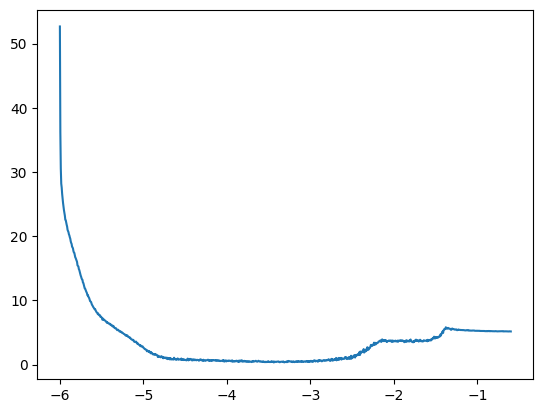

In [13]:
plt.plot(lrs, losses)

### Test tokenizer

In [5]:
raw_corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]
tknr = BPETokenizer(raw_corpus, target_size=100)

Building vocabulary...: 100%|██████████| 100/100 [00:00<00:00, 9523.98it/s]


In [3]:
tknr = BPETokenizer()
tknr.load_state_dict(torch.load("tokenizers/bpe.pth"))

In [6]:
print(
    tknr.decode(
        tknr(
            [
                "<sos> Hôm nay cứ để nó thế này thôi, mai xem tiếp :D <eos> <pad>",
                "To continue, we need to apply that merge in our splits dictionary. Let’s write another function for this:",
            ]
        )
    )[0]
)

['<unk>', 's', 'o', 's', '<unk>', ' H', '<unk>', 'm', ' ', 'n', 'a', 'y', ' c', '<unk>', ' ', '<unk>', '<unk>', ' ', 'n', '<unk>', ' th', '<unk>', ' ', 'n', '<unk>', 'y', ' th', '<unk>', 'i', ',', ' ', 'm', 'a', 'i', ' ', '<unk>', 'e', 'm', ' t', 'i', '<unk>', 'p', ' ', '<unk>', '<unk>', ' ', '<unk>', 'e', 'o', 's', '<unk>', ' ', '<unk>', 'p', 'a', 'd', '<unk>']


In [ ]:
a = [1, 3, 5, 6, 9, 7, 8, 9, 8, 10, 8]
b = [1, 3, 5, 6, 8, 10, 3, 8]

print(bleu_score([a], [b], tknr))
print(sentence_bleu([b], a, (1.0,)))

0.6363636363636364
0.6363636363636364


### Test training

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_args = VanillaTransformerArgs(
    vocab_size=21,
    n_heads=4,
    n_blocks=2,
    d_model=16,
    d_ff=4 * 16,
    d_k=16 // 4,
    d_v=16 // 4,
    max_length=20,
    p_drop=0.2,
)


model = Transformer(model_args).to(device)
count_params(model)

optimizer = Adam(model.parameters(), lr=0.002, betas=(0.98, 0.99), weight_decay=0.01)
scheduler = ExponentialLR(optimizer, 0.999**0.125)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

Total: 15,333 parameters.
Trainable: 15,333 parameters.


In [15]:
sample_data = torch.arange(1, 21).view(-1, 10).to(device)
sample_lens = torch.LongTensor([10] * 2).to(device)
sample_mask1 = create_pad_mask(sample_lens).to(device)
sample_mask2 = create_subsequent_mask(sample_lens - 1).to(device)

In [ ]:
model.train()
for i in range(2000):
    logits = model(sample_data, sample_mask1, sample_data[:, :-1], sample_mask2)
    #    print(logits.argmax(-1))
    loss = loss_fn(logits.reshape(-1, logits.size(-1)), sample_data[:, 1:].reshape(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())
    scheduler.step()

In [17]:
src_data = torch.arange(8, 18).unsqueeze(0).to(device)
src_lens = torch.LongTensor([10]).to(device)
src_mask = create_pad_mask(src_lens).to(device)

tgt_data = torch.LongTensor([[2, 3, 4]]).to(device)
tgt_lens = torch.LongTensor([3]).to(device)
tgt_mask = create_subsequent_mask(tgt_lens).to(device)

model.eval()
with torch.inference_mode():
    encoder_outputs = model.encode(src_data, src_mask)
    for i in range(12):
        logits = model.generate(tgt_data, tgt_mask, encoder_outputs, src_mask)
        # print(logits.argmax(-1))
        n = logits.softmax(-1).argmax(-1)[:, [-1]]
        tgt_data = torch.cat([tgt_data, n], dim=1).to(device)
        tgt_lens += 1
        tgt_mask = create_subsequent_mask(tgt_lens).to(device)

print(tgt_data)

tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10,  5,  6,  7,  8,  9, 10]],
       device='cuda:0')


### Test trained model

In [2]:
tokenizer = BPETokenizer()
tokenizer.load_state_dict(torch.load("tokenizers/bpe-20k.pth"))

In [3]:
max_length = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = len(tokenizer)

In [4]:
vi_en_ids = load_from_disk("datasets/processed_ids_splits_20k")

vi_en_ids = vi_en_ids.filter(
    lambda batch: 2 < len(batch["ids_vi"]) <= max_length
    and 1 <= len(batch["ids_en"]) <= max_length
)

Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/processed_ids_splits_20k/train/cache-7b83163e58bc9652.arrow
Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/processed_ids_splits_20k/test/cache-bc0e3500dc9f3bb7.arrow
Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/processed_ids_splits_20k/val/cache-bfbe0133f43a0ea4.arrow


In [6]:
model_args = VanillaTransformerArgs(
    vocab_size=vocab_size,
    n_heads=4,
    n_blocks=4,
    d_model=128,
    d_ff=4 * 128,
    d_k=32,
    d_v=32,
    max_length=max_length,
    p_drop=0.1,
    bias=False,
)

model = Transformer(model_args).to(device)

#### 1. Test model's capability of overfitting (val set)

In [ ]:
model.load_state_dict(
    torch.load(f"checkpoints/translation-{model_args.d_model}-{model_args.n_blocks}-{model_args.n_heads}-{model_args.vocab_size//1000}k-overfit.pth")
)
_ = model.eval()

In [6]:
val_ds = TextPairDataset(vi_en_ids["val"]["ids_en"], vi_en_ids["val"]["ids_vi"])

In [9]:
src, src_len, tgt, tgt_len = val_ds[random.randint(0, len(val_ds) - 1)]
hehe = "".join(tokenizer.decode(src))
print(hehe)
print("".join(tokenizer.decode(tgt)))
print(translate_one_sentence(model, tokenizer, device, hehe, 100))

so , last month , the encyclopaedia britannica announced that it is going out of print after 244 years , which made me nostalgic , because i remember playing a game with the colossal encyclopedia set in my hometown library back when i was a kid , maybe 12 years old .
<sos>khoảng tháng trước , bách khoa toàn thư britannica thông báo rằng nó sẽ ngừng in xuất bản sau 244 năm , điều đó khiến tôi luyến tiếc , bởi vì tôi nhớ chơi một trò chơi với bách khoa toàn thư khổng lồ được đặt trong thư viện thành phố quê nhà của tôi khi tôi là một đứa trẻ , tầm 12 tuổi .<eos>
<sos>khoảng tháng trước , bách khoa toàn thư britannica thông báo rằng nó sẽ ngừng in xuất bản sau 244 năm , điều đó khiến tôi luyến tiếc , bởi vì tôi nhớ chơi một trò chơi với bách khoa toàn thư khổng lồ được đặt trong thư viện thành phố quê nhà của tôi khi tôi là một đứa trẻ , tầm 12 tuổi .<eos>


#### 2. Actual test

In [7]:
model.load_state_dict(
    torch.load(
        f"checkpoints/translation-{model_args.d_model}-{model_args.n_blocks}-{model_args.n_heads}-{model_args.vocab_size//1000}k.pth"
    )
)
_ = model.eval()

In [8]:
translate_one_sentence(
    model,
    tokenizer,
    device,
    "In school , we spent a lot of time studying the history of Kim Il-Sung , but we never learned much about the outside world , except that America , South Korea , Japan are the enemies .",
    max_tokens=100,
    do_sample=True,
    temperature=0.5,
    top_k=20,
)

'<sos>trong trường học , chúng tôi đã dành rất nhiều thời gian nghiên cứu lịch sử kim loại cắt ghép xương và chúng tôi chưa bao giờ học được nhiều về thế giới bên ngoài , ngoại trừ nước mỹ , hàn quốc , nhật bản là kẻ thù .<eos>'

In [9]:
test_ds = TextPairDataset(vi_en_ids["test"]["ids_en"], vi_en_ids["test"]["ids_vi"])

In [10]:
orgs = []
hypos = []
refs = []

for i in tqdm(range(len(test_ds))):
    src, src_len, tgt, tgt_len = test_ds[i]

    orgs.append(("".join(tokenizer.decode(src)).strip().split()))

    hypos.append(
        translate_one_sentence(
            model,
            tokenizer,
            device,
            "".join(tokenizer.decode(src)),
            max_tokens=max_length,
        )
        .replace("<sos>", "")
        .replace("<eos>", "")
        .strip()
        .split()
    )

    refs.append(
        (
            "".join(tokenizer.decode(tgt))
            .replace("<sos>", "")
            .replace("<eos>", "")
            .strip()
            .split()
        )
    )

  0%|          | 0/1268 [00:00<?, ?it/s]

In [12]:
print(
    f"translation-{model_args.d_model}-{model_args.n_blocks}-{model_args.n_heads}-{model_args.vocab_size//1000}k-vocab{'' if model_args.bias else '-no-bias'}: {sum(sentence_bleu([ref], hypo) for ref, hypo in zip(refs, hypos)) / len(refs):.5}"
)

translation-128-4-4-20k-vocab-no-bias: 0.23028


In [22]:
a = random.randint(0, len(refs) - 1)
print(" ".join(orgs[a]))
print(" ".join(hypos[a]))
print(" ".join(refs[a]))

our shared spaces can better reflect what matters to us as individuals and as a community , and with more ways to share our hopes , fears and stories , the people around us can not only help us make better places , they can help us lead better lives .
những không gian chung của chúng ta có thể phản ánh những gì quan trọng hơn đối với chúng ta với cá nhân và với tư cách cộng đồng , và với nhiều cách để chia sẻ niềm tin , nổi sợ và những câu chuyện , những người xung quanh chúng ta không chỉ giúp chúng ta làm nên những nơi tốt đẹp hơn , mà họ có thể giúp chúng ta sống tốt hơn .
những không gian được chia sẻ của chúng ta có thể tốt hơn được phản ánh về những điều xảy ra cho chúng ta như là những cá thể và như là một cộng đồng , và với nhiều cách hơn để chia sẻ hy vọng , nỗi sợ hãi và những câu chuyện , những người xung quanh chúng ta không chỉ có thể giúp chúng ta làm những nơi tốt đẹp hơn , họ có thể giúp chúng ta dẫn dắt cuộc sống tốt hơn .
